In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

In [74]:
def load_data(lowres_image_path, highres_image_path):
    
    lowres_image = tf.io.read_file(lowres_image_path)
    lowres_image = tf.image.decode_png(lowres_image, channels=3)
    
    lowres_crop_size = 24
    lowres_img_shape = tf.shape(lowres_image)[:2]
    
    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )
    
    lowres_image = lowres_image[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ] 
    
    highres_image = tf.io.read_file(highres_image_path)
    highres_image = tf.image.decode_png(highres_image, channels=3)
    
    highres_crop_size = lowres_crop_size * 8
    highres_height = lowres_height * 8
    highres_width = lowres_width * 8
    
    highres_image = highres_image[
        highres_height : highres_height + highres_crop_size,
        highres_width : highres_width + highres_crop_size,
    ]
    return lowres_image, highres_image

def data_generator(lowres_images, highres_images):
    dataset = tf.data.Dataset.from_tensor_slices((lowres_images, highres_images))
    dataset = dataset.map(load_data, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(16, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

train_lowres_images = sorted(glob("D:/DIV2K/DIV2K_train_LR_x8/*"))
train_highres_images = sorted(glob("D:/DIV2K/DIV2K_train_HR/*"))
valid_lowres_images = sorted(glob("D:/DIV2K/DIV2K_valid_LR_x8/*"))
valid_highres_images = sorted(glob("D:/DIV2K/DIV2K_valid_HR/*"))

train_dataset = data_generator(train_lowres_images, train_highres_images)
valid_dataset = data_generator(valid_lowres_images, valid_highres_images)

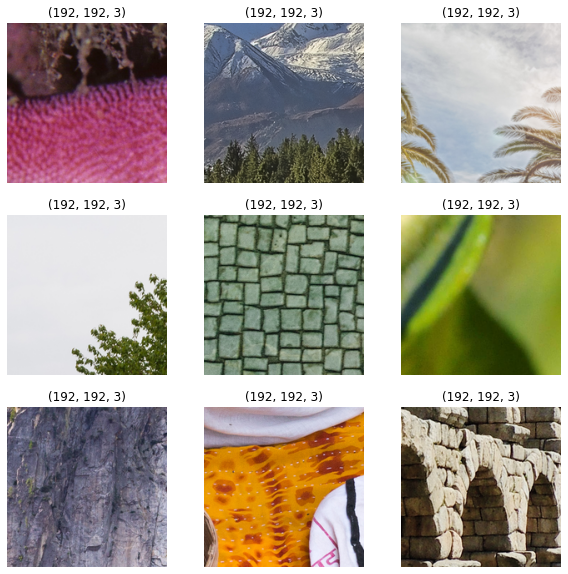

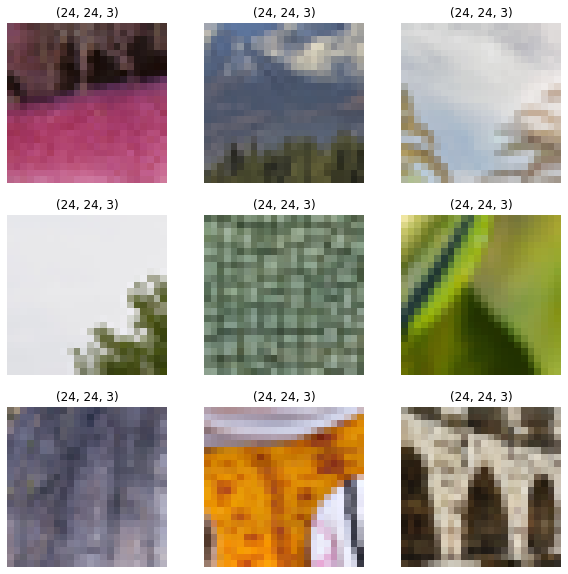

In [75]:
lowres, highres = next(iter(train_dataset))

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")

In [61]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

In [76]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):

    input_layer = layers.Input(shape=(None, None, 3))

    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = Upsampling(x)
    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

In [81]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[2500], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
# Training for more epochs will improve results
model.fit(train_dataset, epochs=100, validation_data=valid_dataset, shuffle=True)

Epoch 1/100
50/50 [==============================] - 6s 89ms/step - loss: 15.0176 - PSNR: 22.3148 - val_loss: 12.9708 - val_PSNR: 22.8016
Epoch 2/100
50/50 [==============================] - 4s 86ms/step - loss: 12.5615 - PSNR: 23.8914 - val_loss: 12.7193 - val_PSNR: 23.7185
Epoch 3/100
50/50 [==============================] - 4s 86ms/step - loss: 12.9419 - PSNR: 23.9406 - val_loss: 12.2400 - val_PSNR: 24.3665
Epoch 4/100
50/50 [==============================] - 5s 90ms/step - loss: 12.7773 - PSNR: 24.2284 - val_loss: 12.1368 - val_PSNR: 23.5866
Epoch 5/100
50/50 [==============================] - 5s 89ms/step - loss: 12.2015 - PSNR: 24.7865 - val_loss: 12.0788 - val_PSNR: 26.3151
Epoch 6/100
50/50 [==============================] - 4s 88ms/step - loss: 12.5368 - PSNR: 24.2501 - val_loss: 12.4304 - val_PSNR: 26.3046
Epoch 7/100
50/50 [==============================] - 4s 85ms/step - loss: 12.3892 - PSNR: 23.7812 - val_loss: 12.4116 - val_PSNR: 25.2267
Epoch 8/100
50/50 [===============

50/50 [==============================] - 5s 94ms/step - loss: 10.5395 - PSNR: 26.7792 - val_loss: 8.8899 - val_PSNR: 23.1614
Epoch 61/100
50/50 [==============================] - 5s 94ms/step - loss: 11.0572 - PSNR: 25.5607 - val_loss: 11.0287 - val_PSNR: 23.4997
Epoch 62/100
50/50 [==============================] - 5s 94ms/step - loss: 10.5801 - PSNR: 26.3252 - val_loss: 10.1390 - val_PSNR: 28.2268
Epoch 63/100
50/50 [==============================] - 5s 98ms/step - loss: 10.8832 - PSNR: 24.7080 - val_loss: 10.4601 - val_PSNR: 26.8514
Epoch 64/100
50/50 [==============================] - 5s 95ms/step - loss: 10.8488 - PSNR: 26.3837 - val_loss: 11.3306 - val_PSNR: 23.3878
Epoch 65/100
50/50 [==============================] - 5s 95ms/step - loss: 10.7859 - PSNR: 26.3460 - val_loss: 11.0339 - val_PSNR: 26.4320
Epoch 66/100
50/50 [==============================] - 5s 96ms/step - loss: 10.7753 - PSNR: 25.9501 - val_loss: 10.9971 - val_PSNR: 26.5185
Epoch 67/100
50/50 [=====================

In [107]:
def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(20, 10))
    plt.subplot(121), plt.imshow(lowres), plt.title("Low resolution"), plt.axis('off')
    plt.subplot(122), plt.imshow(preds), plt.title("Prediction"), plt.axis('off')
    plt.show()

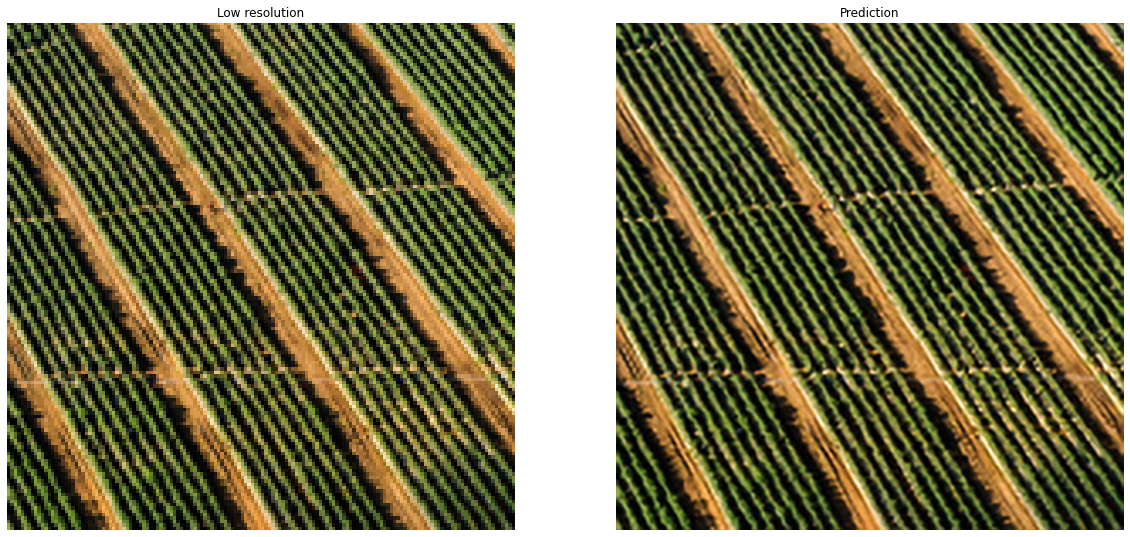

In [112]:
import random
idx = random.randint(0, 100)
image = tf.io.read_file(valid_lowres_images[idx])
image = tf.image.decode_png(image, channels=3)
crop_image = tf.image.random_crop(image, (150, 150, 3))
preds = model.predict_step(crop_image)
plot_results(crop_image, preds)